This is a quick example showing how to use the code with the ISBI 2012 data set.

Note that the sample weights provided here are *not* the best possible - for best results one would want to train for longer.

In [14]:
%matplotlib inline

import os, sys, time
from socket import gethostname

import numpy as np
import pylab as plt

np.random.seed(9999)

import keras
from keras import backend as K
from keras.models import load_model

sys.path.append('../..')
from cnn_tools import *
from data_tools import *


K.set_image_dim_ordering('th')

print('Using Keras version: %s' % keras.__version__)

Using Keras version: 1.1.1


In [12]:
# load test data
isbi_dir = os.path.expanduser('~/Data/ISBI-2012')
X_test = load_multilayer_tiff(os.path.join(isbi_dir, 'test-volume.tif'))
X_test = X_test / 255.
    
print('[info]: test data has shape:     %s' % str(X_test.shape))

# load model
model = create_unet((1, 256, 256))
model.load_weights('./weights_epoch0011.hdf5')

[info]: test data has shape:     (30, 1, 512, 512)


In [15]:
# deploy
tic = time.time()
Y_hat = deploy_model(X_test, model)
print('[info]: total time to deploy on system "%s": %0.2f sec' % (gethostname(), (time.time() - tic)))

[info]: total time to deploy on system pekalmj1-ml2: 101.94 sec


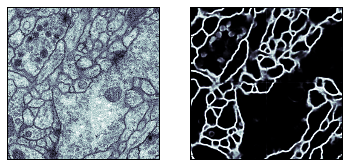

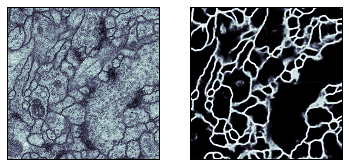

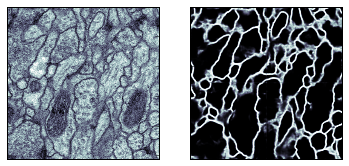

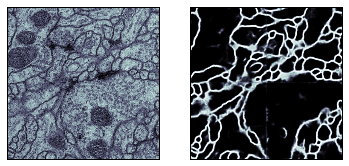

In [13]:
# visualize
def my_imshow(X):
    plt.imshow(X, cmap='bone')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelleft='off', labelbottom='off')

for z in [0, 9, 19, 29]:
    plt.subplot(1,2,1)
    my_imshow(X_test[z,0,...])
    plt.subplot(1,2,2)
    my_imshow(Y_hat[z,0,...])
    plt.show()
